
# **Tolman-Oppenheimer-Volkoff equation solver. Classical polytrope and MIT bag model. Semiclassical and torsional corrections.**
The TOV equations are given by the following formula:
\begin{equation}
\frac{dp}{dr}=-G\left(\rho\left(1+\frac{\epsilon}{c^2}\right)+\frac{p}{c^2}\right)\frac{m+4\pi r^3p/c^2}{r(r-2Gm/c^2)} \tag{1}
\end{equation}
\begin{equation}
\frac{dm}{dr}=4\pi r^2 \rho(1+\epsilon/c^2) \tag{2}
\end{equation}
\begin{equation}
\frac{d\phi}{dr}=\frac{m+4\pi r^3p/c^2}{r(r-2Gm/c^2)} \tag{3}
\end{equation}

Now these equations become closed when we specify pressure-density (equation of state or EOS) dependence. We took two models into account MIT bag and Polytropic model:

$$p_{mit}=\frac{\rho c^2 - 4 B}{3} \tag{4}$$
$$p_{poly}=K \rho^{\gamma} \tag{5}$$

First let us write down all the coefficients that will be used in calculations. CGS units were used.

**Define the bag constant  and polytropic constant that is going to be used in whole program**. To do that use *bag_const_def* and *poly_const_def* functions. By choosing bag constant you also define the minimum value for the central density, otherwise pressure could become negative:

$$\rho c^2 - 4 B>0$$


In [0]:
import numpy as np
import matplotlib.pyplot as plt

ggrav = 6.673E-8
clite = 2.99792458E10
g_c2 = ggrav/clite**2
msun = 1.98892E33
minpress=1E-10 #minpress is used so that press doesnt become negative
gamma=2.5

#makes conversion between Mev/fm^3 and SI units
#and defines min possible density so that pressure
#does not become negative
#it is in cgs units
def bag_const_def(b_const):
  conversed_b = b_const*1.602176E33
  min_rho = 4*conversed_b/clite**2
  return conversed_b,round(min_rho/1.0E14)

#defines values of k constant for different
#values of gamma
def poly_const_def(gamma_):
  k_guess=1.98183E-6
  rho_guess=2E14
  press_guess=k_guess*(rho_guess)**2.75
  k = press_guess/(rho_guess)**gamma_ #poly const for particular gamma
  return k

#bag const!!
Beos,rho_min=bag_const_def(50)

#polytropic constant K!!
k_poly=round(poly_const_def(gamma),9)

Now let us define number of zones (we devide star for small integration zones) and maximum allowed radius:

In [0]:
nzones = 4000 #number of zones 
rmax  = 1.5E6 # 15 km
dr = rmax/(nzones-1) #xstep 

We also define global variables that are used to calculate thermodynamic properties at each integration step.

In [0]:
#allocate parameters used in integration  
mgrav=np.zeros(nzones)
press=np.zeros(nzones)
rho=np.zeros(nzones)
rs=np.zeros(nzones)
mgrav_e=np.zeros(nzones)
press_e=np.zeros(nzones)


#radius at each zone
rs[0]=0.01
for i in range(1,nzones):
  rs[i]=rs[i-1]+dr

**We** use *func_eval* to pass function names into functions. This will be clear later on.

In [0]:
def func_eval(funcName, *args): 
    return eval(funcName)(*args)

In the next cell, we define all the functions that are going to be used to calculate thermodynamic properties of the star. *Reveos* means reversed EOS to calculate density when pressure value is given. The need for this function could be seen from PDEs given above. As you can see only pressure and gravitational mass are calculated at each subsequent step *$r_i$+dr*, but not density (cause press and mass derivative given only). To calculate density at step *$r_i$+dr*, we have to use EOS with pressure value at this step. 


In [0]:
#mit bag model eos
def eos_mit(rho_):
  return (rho_*clite**2-4*Beos)/3
#polytrope model eos
def eos_poly(rho_):
  return k_poly*rho_**gamma

#reversed eos to define value of density
#for semiclassical corrections:
#MIT semiclassical 
def reveos_mit(press_,*args): 
  press_=max(minpress,press_)
  rho_= (3*press_+4*Beos)/clite**2 
  return rho_
#Polytrope semiclassical
def reveos_poly(press_,*args): 
  press_=max(minpress,press_)
  rho_= (press_/k_poly)**(1/gamma) 
  return rho_



Next we introduce corrections to the EOS. Two corrections were considered: semiclassical and polytropic. In the case of semiclassical corrections density is substracted by the factor which depends on "physical" density and critical density. Then pressure is calculated by EOS (4-5). The variables are called "effective" due to their unphysical nature. 
$$\rho_{eff}=\rho - \frac{\rho^2}{\rho_{cr}} \tag{6}$$
$$p_{eff}=p(\rho_{eff}) \tag{7}$$

In the case of torsional corrections one needs to use same eq. (6) for corrections in density, but effective pressure is calculated in different way. Corrections depend on "physical" density and critical density.  
$$\rho_{eff}=\rho - \frac{\rho^2}{\rho_{cr}} \tag{8}$$
$$p_{eff}=p-\frac{\rho^2c^2}{\rho_{cr}} \tag{9} $$



In [0]:
def semi(rho_cent,rho_crit): #semiclassical corrections
  return rho_cent - rho_cent**2/rho_crit

def torsion(rho_cent,press_,rho_crit): #Torsional corrections
  temprho = rho_cent - rho_cent**2/rho_crit
  tempress = press_ - clite**2*rho_cent**2/rho_crit
  return tempress

As you can see, torsion case is special since there is no analytic expression to define effective density from pressure value. That is why we use Newton-Raphson algorithm.
First one need to define physical density from eq. (8). Then using either Polytropic (5) or MIT (4) EOS define relation between effective density and effective pressure:
 $$\rho=\rho(\rho_{eff})\longrightarrow p_{eff}=p(\rho_{eff})-\rho(\rho_{eff})$$
Once relation is found one can solve for $rho_{eff}$ using Newton-Raphson method.

In [0]:
#newton-raphson algorithm to define density value from pressure MIT EOS
def reveos_torsion_mit(press_,rho_crit):
  pts=20
  tp=np.zeros(pts)
  tp[0]=1E15 #initial guess
  ii=0
  while abs(tp[ii+1]-tp[ii])/tp[0]>1E-10: #for ii in range(pts-1):
    if ii==pts-2:
      break
    else:
      te =  rho_crit/2*(1-(1-4*tp[ii]/rho_crit)**0.5) #temporary variable 
                                                      #to ease calculations
      #equation as it is  
      eqn = (te*clite**2-4*Beos)/3 - (clite*tp[ii])**2/rho_crit-press_
      #derivative of the equation
      deqn = clite**2*(1 - 2/(3*(1 - 4*tp[ii]/rho_crit)**0.5)) 
      tp[ii+1]=tp[ii] - eqn/deqn #Newton-Raphson formula
      rho_eff=tp[ii+1]
    ii=ii+1
  return rho_eff 
  

#newton-raphson algorithm to define density value from pressure Poly EOS
def reveos_torsion_poly(press_,rho_crit):
  pts=20
  tp=np.zeros(pts)
  tp[0]=1E15 #initial guess
  ii=0
  while abs(tp[ii+1]-tp[ii])/tp[0]>1E-10: #for ii in range(pts-1):
    if ii==pts-2:
      break
    else:
      t=rho_crit/2*(1-(1-4*tp[ii]/rho_crit)**0.5)
      m=rho_crit*(1-(1-4*tp[ii]/rho_crit)**0.5)
      l = (1-4*tp[ii]/rho_crit)**0.5
      h = 0.2973017*gamma*k_poly
      eqn = k_poly*t**gamma - (clite*t)**2/rho_crit-press_
      deqn = ((h*m**(gamma-1)) - m*clite**2/rho_crit)/l
      tp[ii+1]=tp[ii] - eqn/deqn #Newton-Raphson formula
      rho_eff=tp[ii+1]
    ii=ii+1
  return rho_eff 

Now we define RHS of PDEs. It was divided to *classical* and *modified* as they are different from each other. In the classical case equations (1) - (3) were used as they are, while in modified case 
$$\frac{dp_{eff}}{dr}=f(p_{eff},m_{eff},\rho_{eff}) \tag{10}$$
$$\frac{dm_{eff}}{dr}=g(\rho_{eff}) \tag{11}$$
$$\frac{dm}{dr}=g(\rho) \tag{12}$$ 
additional mass derivative passed to integration algorigthm (*f* and *g* are given by equation (1) and (2) respectively). This is done in order to determine physical gravitational mass of the star. The reason is that for calculating the object’s mass in the semi-classical case, one has to use equation (12) with the physical density ρ, while the boundary radius Rb is obtained from integration of the effective eTOV (10), (11) equation.

In [0]:
def RHS_cl(p_and_m,r_,*args):  #RHS of PDE
  press_=p_and_m[0]
  mgrav_=p_and_m[1]
  model =args[1]
  rho_=func_eval(model,press_)
  eps = press_/(gamma - 1.0)/rho_
  mu  = rho_ + rho_*eps/clite**2
  if model=='reveos_poly':
    rho_=mu

  a=(ggrav*(rho_+press_/clite**2)*(mgrav_+4*np.pi*(r_**3)*press_/clite**2)
     /(r_*(2*g_c2*mgrav_-r_))) #dp/dr
  b=4*np.pi*(r_**2)*rho_ #dm/dr
  y=[]
  y.append(a)
  y.append(b)
  return y

def RHS_modified(p_and_m,r_,*args):  #RHS of PDE of modified
  press_e_=p_and_m[0] 
  mgrav_=p_and_m[1]
  mgrav_e_=p_and_m[2]
  rho_crit=args[0]
  reveos_func=args[1] #the name of function used to calculate density
                      #it could be:(reveos_mit),(reveos_torsion_mit)
                      #(reveos_poly),(reveos_torsion_poly)
  
  rho_e_=func_eval(reveos_func,press_e_,rho_crit) #calc eff density
  rho_ = rho_crit/2*(1-(1-4*rho_e_/rho_crit)**0.5) #calc physical density 
                                                   #from eff density
  eps=0.0
  if rho_==0.0:
    press_ = 0.0
  else:
    press_ =func_eval('eos_poly',rho_)
    eps = press_/(gamma-1.0)/rho_
  
  mu_e = rho_e_+rho_e_*eps/clite**2
  mu = rho_ + rho_*eps/clite**2
  if reveos_func=='reveos_poly':  #in the case of MIT bag model we take eps=0
    rho_e_=mu_e
    rho_ = mu
  elif reveos_func=='reveos_torsion_poly':
    rho_e_=mu_e
    rho_ = mu    
  a=(ggrav*(rho_e_+press_e_/clite**2)*   #dp_eff/dr
     (mgrav_e_+4*np.pi*(r_**3)*press_e_/clite**2)/(r_*(2*g_c2*mgrav_e_-r_))) 
  b=4*np.pi*(r_**2)*rho_ #dm_eff/dr
  c=4*np.pi*(r_**2)*rho_e_ #dm_phys/dr
  y=[]
  y.append(a)
  y.append(b)
  y.append(c)
  return y

[Runge–Kutta–Fehlberg](https://https://en.wikipedia.org/wiki/Runge%E2%80%93Kutta%E2%80%93Fehlberg_method) method was used to calculate mass and pressure at each subsequent step.

In [0]:
def RKF45(RHS_func,invar,step,*args):
  x=step
  num=len(invar)
  tmp_dat=np.zeros(num)
  sol=np.zeros(num)
  rho_crit=args[0]
  reveos_func=args[1]
  
  k1 = func_eval(RHS_func,invar,x,rho_crit,reveos_func)
  
  for i in range(num):
    tmp_dat[i] = invar[i] + k1[i]*(dr/5)
  
  k2 = func_eval(RHS_func,tmp_dat,x+dr/5,rho_crit,reveos_func)
  
  for i in range(num):
    tmp_dat[i] = invar[i] + k1[i]*(3*dr/40) + k2[i]*(9*dr/40)
  
  k3 = func_eval(RHS_func,tmp_dat,x+(3*dr/10),rho_crit,reveos_func)
  
  for i in range(num):
    tmp_dat[i] = invar[i] + k1[i]*(3*dr/10) - k2[i]*(9*dr/10) + k3[i]*(6*dr/5)

  k4 = func_eval(RHS_func,tmp_dat,x+(3*dr/5),rho_crit,reveos_func)
  
  for i in range(num):
    tmp_dat[i] = (invar[i] - k1[i]*(11*dr/54) + k2[i]*(5*dr/2) - 
                  k3[i]*(70*dr/27) + k4[i]*(35*dr/27))

  k5 = func_eval(RHS_func,tmp_dat, x+dr,rho_crit,reveos_func)
  
  for i in range(num):
    tmp_dat[i] = (invar[i] + k1[i]*(1631*dr/55296) + k2[i]*(175*dr/512) + 
                  k3[i]*(575*dr/13824) + 
                  k4[i]*(44275*dr/110592) + 
                  k5[i]*(253*dr/4096))
    
  k6 = func_eval(RHS_func,tmp_dat,x+(7*dr/8),rho_crit,reveos_func)

  for j in range(num):
    sol[j] = (invar[j] + dr*(37*k1[j]/378 + 250*k3[j]/621 + 
                             125*k4[j]/594 + 512*k6[j]/1771))
     
  return  sol #press and mgrav

Number of central densities used to calculate $M-R_b$ plot

In [0]:
n=100 #central initial densities

**Classical TOV solver for polytrope and MIT bag model.** 

For classical case Equations (1), (2) used as they are. 

If one interested in **TOV classical solver**, the code presented over here is just **enough**. The rest of the code related to the paper results. 

1st loop here is used to sweep through central densities which are given by *rho_cit*.  So *rho_cit[i]* sets central density and initial values of mass and pressure are calculated through EOS.

Then 2nd loop sweep through all the integration zones. *tempvar* variable is used to pass previous pressure and mass values to RKF45 algorithm and calculate current pressure and mass values. Then *while* function is used to define the point where pressure becomes negative stating the point of boundary of the star. After that boundary radius and mass for given *rho_cit* are stored in *rb* and *M* arrays respectively.




In [0]:
def TOV_cl(n_cden,model):
  num_of_var=2
  rho_cit=np.zeros(n_cden)
  rb = np.zeros(n_cden)
  M = np.zeros(n_cden)
  tempvar=np.zeros(num_of_var)
  
  temppress=np.zeros((n_cden,nzones))
  for i in range(n_cden): #1st loop
    if model=='poly':
      rho_cit[i]=1.0E14+i*0.25E14
    elif model=='mit':
      rho_cit[i]=rho_min*1.0E14 + (i+2)*0.25E14

  #initial values

    rho[0]=rho_cit[i]
    press[0]=func_eval('eos_{}'.format(model),rho[0])  
    mgrav[0]=(4*np.pi*rho[0]*rs[0]**3)/3.0


    for j in range(1,nzones): #2nd loop
      tempvar[0]=max(press[j-1],minpress)
      tempvar[1]=mgrav[j-1]
      press[j],mgrav[j]=RKF45('RHS_cl',tempvar,rs[j-1],1,#here rho_crit and 
                              'reveos_{}'.format(model)) #reveos_func taken as 1
      #do not delete them, cause RKF45 requires them to be passed
      #they are not used in classical case                                                
      
      
      #rho[j] = reveos_mit(press[j]) #enable this (return too) if you need
                                     #density profile
    
    k=0
    while press[k]>0:
      k=k+1
    isurf=k-1 
    rb[i]=rs[isurf]/1E5
    M[i]=mgrav[isurf]/msun
    temppress[i,:]=press
  return rb,M,temppress#,mgrav,rho 


**Modified TOV solver.**
**Semiclassical correction to EOS was used**. 

It almost the same as in classical case, with difference in the 1st loop. 1st loop is used to calculate critical densities, that are on turn is used to define effective pressure and mass. String typed variable  is used to differentiate between *polytropic* and *MIT* EOS.


Critical density values in this case: 1.5E16, 4E16, 1E17

In [0]:
def TOV_semi(n_cden,model):
  num_of_var=3
  num_of_crden=3 #number of critical densities
  tempvar=np.zeros(num_of_var)
  M=np.zeros((num_of_crden,n_cden))
  rb=np.zeros((num_of_crden,n_cden))
  rho_cr=np.zeros(num_of_crden)
  rho_cit=np.zeros(n_cden)
  
  temppress=np.zeros((num_of_crden,n_cden,nzones))
  #tempmass=np.zeros((num_of_crden,n_cden,nzones))  #use this if you need
  #temprho=np.zeros((num_of_crden,n_cden))          #mass and density profiles
  for g in range(1,4):
    rho_cr[g-1]=(1.75*g**2-2.75*g+2.5)*1.0E16
    for i in range(n_cden):
      if model=='poly':
        rho_cit[i] =1.0E14+i*0.25E14#
      elif model=='mit':
        rho_cit[i]=rho_min*1.0E14 + (i+2)*0.25E14#
  
      #initial values
      rho[0]=semi(rho_cit[i],rho_cr[g-1]) #effective rho
      #physical and effective masses
      mgrav[0]=(4*np.pi*rho_cit[i]*rs[0]**3)/3.0
      mgrav_e[0]=(4*np.pi*rho[0]*rs[0]**3)/3.0
      #physical and effective pressure 
      press[0]=func_eval('eos_{}'.format(model),rho_cit[i])
      press_e[0]=func_eval('eos_{}'.format(model),rho[0])
      
      
      
      for j in range(1,nzones):
        tempvar[0]=max(press_e[j-1],minpress)
        tempvar[1]=mgrav[j-1]
        tempvar[2]=mgrav_e[j-1]
        press_e[j],mgrav[j],mgrav_e[j]=RKF45('RHS_modified',tempvar,rs[j-1],
                                             rho_cr[g-1],
                                             'reveos_{}'.format(model))
        #rho[j] = reveos_mit(press[j])
      k=0
      while press_e[k]>0:
        k=k+1
      isurf1=k-1
      rb[g-1,i]=rs[isurf1]/1E5
      M[g-1,i]=mgrav[isurf1]/msun
      temppress[g-1,i,:]=press_e
      #tempmass[g-1,i,:]=mgrav
      #temprho[g-1,i,:]=rho
  return rb,M,temppress#,tempmass,temprho  

**Modified TOV solver. Torsional correction to EOS was used.** 

It almost the same as in classical case, with difference in the 1st loop. 1st loop is used to calculate critical densities, that are on turn is used to define effective pressure and mass. 

Critical density values in this case: 1E17, 2.5E17, 5E17

In [0]:
def crit_dens_mit(nn):
  return (0.5*nn**2+0.5)*1.0E17
def crit_dens_poly(nn):
  return (nn**2-nn+2)*1.0E17


def TOV_torsion(n_cden,model):
  num_of_var=3
  num_of_crden=3
  tempvar=np.zeros(num_of_var)
  M=np.zeros((3,n_cden))
  rb=np.zeros((3,n_cden))
  rho_cr=np.zeros(3)
  rho_cit=np.zeros(n_cden)
  
  temppress=np.zeros((num_of_crden,n_cden,nzones))
  #tem]pmass=np.zeros((num_of_crden,n_cden,nzones)) #use this if you need
  #temprho=np.zeros((num_of_crden,n_cden))          #mass and density profiles
  
  for g in range(1,4):
    rho_cr[g-1]=func_eval('crit_dens_{}'.format(model),g)
    for i in range(n):
      if model=='poly':
        rho_cit[i] =1.0E14+i*0.25E14
        
      elif model=='mit':
        rho_cit[i] =rho_min*1.0E14+(i+2)*0.25E14
      #initial values
      rho[0]=semi(rho_cit[i],rho_cr[g-1])
      
      mgrav[0]=(4*np.pi*rho_cit[i]*rs[0]**3)/3.0
      mgrav_e[0]=(4*np.pi*rho[0]*rs[0]**3)/3.0
      
      press[0]=func_eval('eos_{}'.format(model),rho_cit[i])
      press_e[0]=torsion(rho_cit[i],press[0],rho_cr[g-1])
      
    
      for j in range(1,nzones):
        tempvar[0]=max(press_e[j-1],minpress)
        tempvar[1]=mgrav[j-1]
        tempvar[2]=mgrav_e[j-1]
        press_e[j],mgrav[j],mgrav_e[j]=RKF45('RHS_modified',
                                             tempvar,rs[j-1],
                                             rho_cr[g-1],
                                             'reveos_torsion_{}'.format(model))
        #rho[j] = reveos_torsion(press[j])
      k=0
      while press_e[k]>0:
        k=k+1
      isurf=k-1
      rb[g-1,i]=rs[isurf]/1E5
      M[g-1,i]=mgrav[isurf]/msun
      temppress[g-1,i,:]=press_e
      #tempmass[g-1,i,:]=mgrav  #this is optional
      #temprho[g-1,i,:]=rho     #and can be used if one want to see   
  return rb,M,temppress         #mass and density profiles

# Solution to TOV equation for classical case and the case with corrections

The final step is to use solvers to calculate all parameters.
First we solve for **MIT bag EOS** without any corrections. The bag const is 60 Mev/fm$^3$.

In [0]:
rb_cl_mit,M_cl_mit,p_cl_mit=TOV_cl(n,'mit') #,p_cl

Then we solve for **semiclassical correction** which are given by eq. (6-7).

In [0]:
rb_semi_mit,M_semi_mit,p_semi_mit=TOV_semi(n,'mit')

Now we solve for **torsional corrections** which are given by eq. (8-9)

In [0]:
rb_tor_mit,M_tor_mit,p_tor_mit=TOV_torsion(n,'mit')

Next we solve for **polytropic EOS** with $\gamma=2.5$.
First is the classical case.

In [0]:
rb_cl_poly,M_cl_poly,p_cl_poly=TOV_cl(n,'poly')

Then we solve for **semiclassical corrections** to **polytropic EOS**.

In [0]:
rb_semi_poly,M_semi_poly,p_semi_poly=TOV_semi(n,'poly')

And finally we obtain solution for **torsional corrections** to **polytropic EOS**.

In [0]:
rb_tor_poly,M_tor_poly,p_tor_poly=TOV_torsion(n,'poly')

# Plots of M-R relation and pressure profile for each case



## Polytropic EOS, Semiclassical corrections

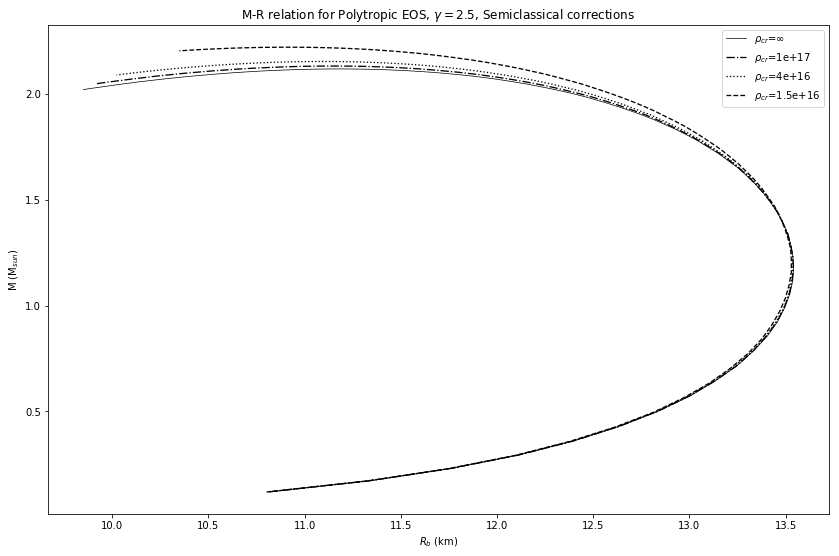

In [0]:
plt.plot(rb_cl_poly,M_cl_poly,'k',lw=0.7,label=r'$\rho_{cr}$=$\infty$')
lines=['--',':','-.']
for i in range(2,-1,-1):
  plt.plot(rb_semi_poly[i],M_semi_poly[i],lines[i],c='k',lw=1.3,
      label=r"$\rho_{cr}$"+'={}'.format((1.75*(i+1)**2-2.75*(i+1)+2.5)*1.0E16))
plt.rcParams['figure.figsize'] = [14,9]
plt.legend()
plt.xlabel('$R_b$ (km)')
plt.ylabel('M (M$_{sun}$)')
plt.title('M-R relation for Polytropic EOS, $\gamma=2.5$, '+
          'Semiclassical corrections')
plt.show()

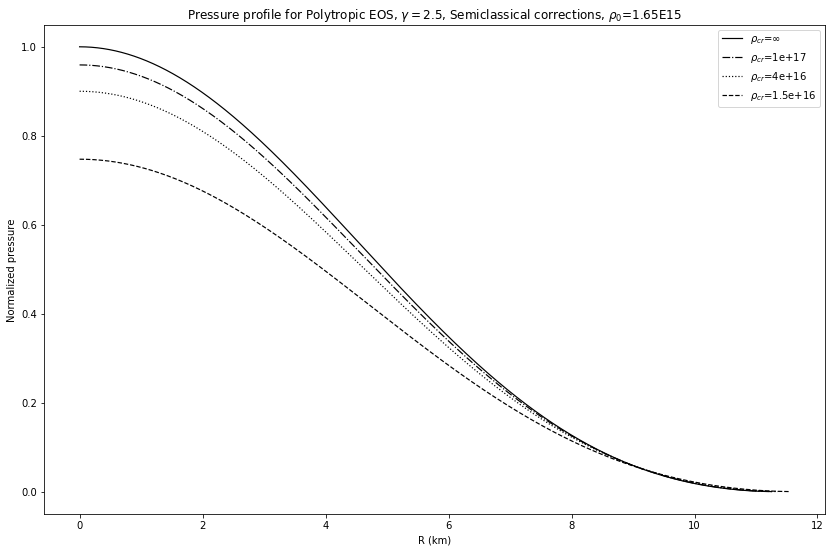

In [0]:
cen_dens=62 #1.65E15
def dens_len_matcher(rb_c,rb_s,nn):
  bound_cl=np.where(rs/1E5 == rb_c[nn])
  boundary_=int(bound_cl[0])
  bry_semi_=np.zeros(3,dtype=int)
  for i in range(3):
      b_semi=np.where(rs/1E5 == rb_s[i,nn])
      bry_semi_[i]=int(b_semi[0])
  return boundary_,bry_semi_
  
boundary,bry_semi=dens_len_matcher(rb_cl_poly,rb_semi_poly,cen_dens)
plt.plot(rs[0:boundary]/1E5,
         p_cl_poly[cen_dens,0:boundary]/p_cl_poly[cen_dens,0],'k',lw=1.2,
         label=r'$\rho_{cr}$=$\infty$')
for i in range(2,-1,-1):
  plt.plot(rs[0:bry_semi[i]]/1E5,
           p_semi_poly[i,cen_dens,0:bry_semi[i]]/p_cl_poly[cen_dens,0],
           lines[i],c='k',
           lw=1.2,
       label=r"$\rho_{cr}$"+'={}'.format((1.75*(i+1)**2-2.75*(i+1)+2.5)*1.0E16))
plt.legend()
plt.rcParams['figure.figsize'] = [14,9]
plt.title('Pressure profile for Polytropic EOS, $\gamma=2.5$'+
          ', Semiclassical corrections,'
          +r' $\rho_0$=1.65E15')
plt.ylabel('Normalized pressure')
plt.xlabel('R (km)')
plt.show()

## Polytropic EOS, Torsional corrections

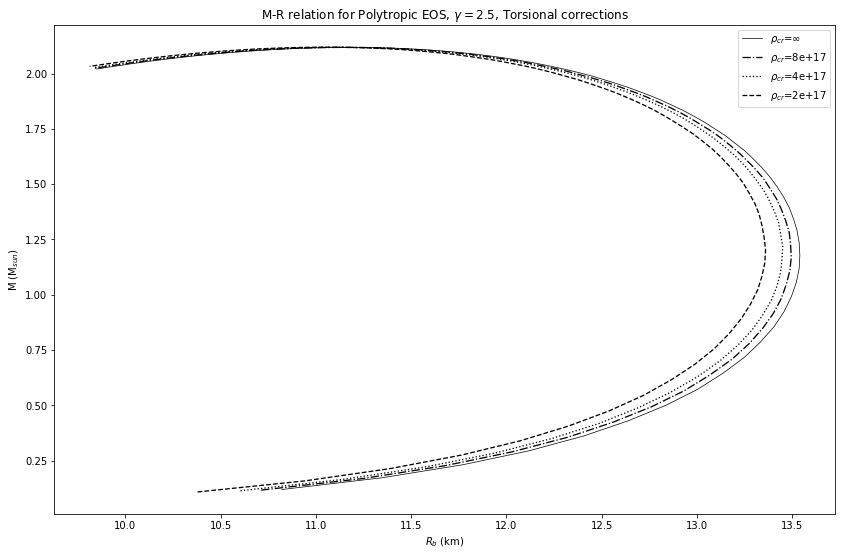

In [0]:
plt.plot(rb_cl_poly,M_cl_poly,'k',lw=0.7,label=r'$\rho_{cr}$=$\infty$')
lines=['--',':','-.']
for i in range(2,-1,-1):
  plt.plot(rb_tor_poly[i],M_tor_poly[i],lines[i],c='k',lw=1.3,
           label=r"$\rho_{cr}$"+'={}'.format(((i+1)**2-(i+1)+2)*1.0E17))
plt.rcParams['figure.figsize'] = [14,9]
plt.legend()
plt.xlabel('$R_b$ (km)')
plt.ylabel('M (M$_{sun}$)')
plt.title('M-R relation for Polytropic EOS, $\gamma=2.5$,'+
          ' Torsional corrections')
plt.show()

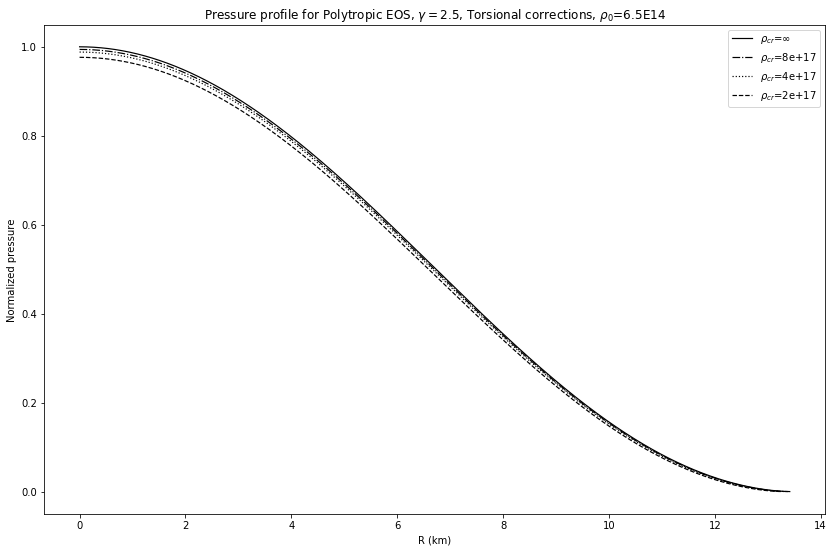

In [0]:
cen_dens=22 #6.5e14
boundary,bry_tor=dens_len_matcher(rb_cl_poly,rb_tor_poly,cen_dens)
plt.plot(rs[0:boundary]/1E5,
         p_cl_poly[cen_dens,0:boundary]/p_cl_poly[cen_dens,0],'k',lw=1.2,
         label=r'$\rho_{cr}$=$\infty$')
for i in range(2,-1,-1):
  plt.plot(rs[0:bry_tor[i]]/1E5,
           p_tor_poly[i,cen_dens,0:bry_tor[i]]/p_cl_poly[cen_dens,0],
           lines[i],c='k',lw=1.2,
           label=r"$\rho_{cr}$"+'={}'.format(((i+1)**2-(i+1)+2)*1.0E17))
plt.legend()
plt.rcParams['figure.figsize'] = [14,9]
plt.title('Pressure profile for Polytropic EOS, $\gamma=2.5$,'+
          ' Torsional corrections,'+r' $\rho_0$=6.5E14')
plt.ylabel('Normalized pressure')
plt.xlabel('R (km)')
plt.show()

##  MIT bag EOS, Semiclassical corrections

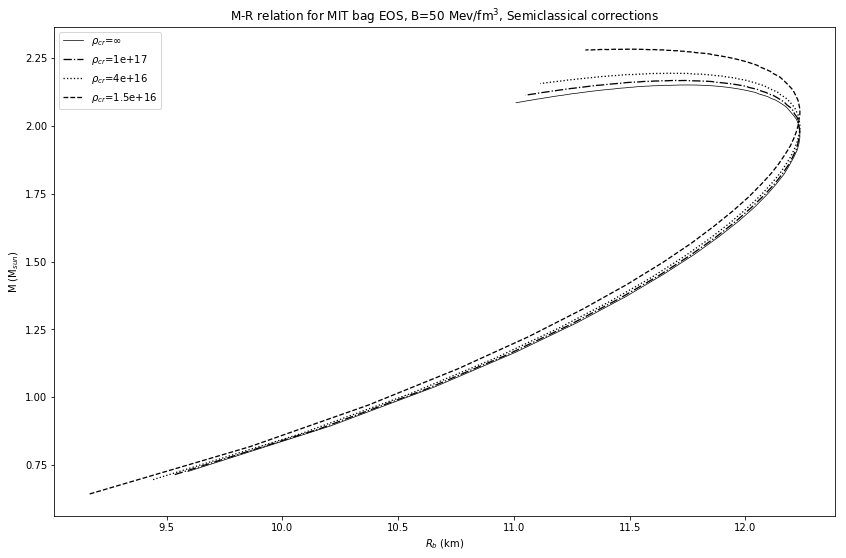

In [0]:
plt.plot(rb_cl_mit,M_cl_mit,'k',lw=0.7,label=r'$\rho_{cr}$=$\infty$')
lines=['--',':','-.']
for i in range(2,-1,-1):
  plt.plot(rb_semi_mit[i],M_semi_mit[i],lines[i],c='k',
      lw=1.3,
      label=r"$\rho_{cr}$"+'={}'.format((1.75*(i+1)**2-2.75*(i+1)+2.5)*1.0E16))
plt.rcParams['figure.figsize'] = [14,9]
plt.legend()
plt.xlabel('$R_b$ (km)')
plt.ylabel('M (M$_{sun}$)')
plt.title('M-R relation for MIT bag EOS, B=50 Mev/fm$^3$, '+
          'Semiclassical corrections')
plt.show()

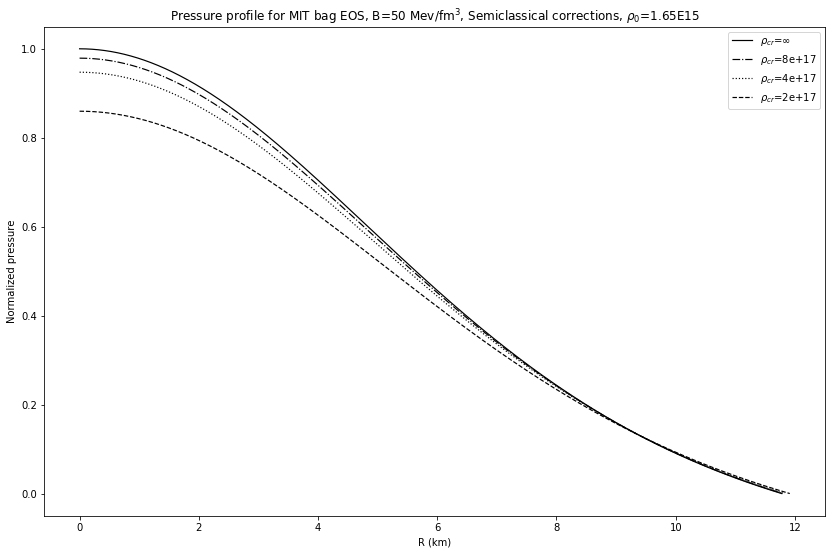

In [0]:
cen_dens=48 #6.5e14
boundary,bry_semi=dens_len_matcher(rb_cl_mit,rb_semi_mit,cen_dens)
plt.plot(rs[0:boundary]/1E5,
         p_cl_mit[cen_dens,0:boundary]/p_cl_mit[cen_dens,0],'k',lw=1.2,
         label=r'$\rho_{cr}$=$\infty$')
for i in range(2,-1,-1):
  plt.plot(rs[0:bry_semi[i]]/1E5,
           p_semi_mit[i,cen_dens,0:bry_semi[i]]/p_cl_mit[cen_dens,0],
           lines[i],c='k',
           lw=1.2,label=r"$\rho_{cr}$"+'={}'.format(((i+1)**2-(i+1)+2)*1.0E17))
plt.legend()
plt.rcParams['figure.figsize'] = [14,9]
plt.title('Pressure profile for MIT bag EOS, '+
          'B=50 Mev/fm$^3$, Semiclassical corrections,'+r' $\rho_0$=1.65E15')
plt.ylabel('Normalized pressure')
plt.xlabel('R (km)')
plt.show()

##  MIT bag EOS, Semiclassical corrections

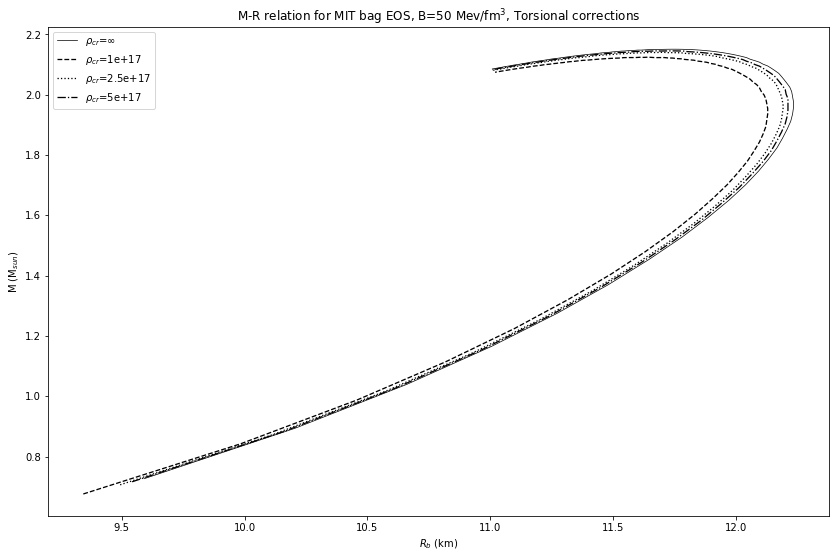

In [0]:
plt.plot(rb_cl_mit,M_cl_mit,'k',lw=0.7,label=r'$\rho_{cr}$=$\infty$')
for i in range(3):
  plt.plot(rb_tor_mit[i],
           M_tor_mit[i],lines[i],
           c='k',lw=1.3,
           label=r"$\rho_{cr}$"+'={}'.format((0.5*(i+1)**2+0.5)*1.0E17))
plt.rcParams['figure.figsize'] = [14,9]
plt.legend()
plt.xlabel('$R_b$ (km)')
plt.ylabel('M (M$_{sun}$)')
plt.title('M-R relation for MIT bag EOS, B=50 Mev/fm$^3$, '+
          'Torsional corrections')
plt.show()

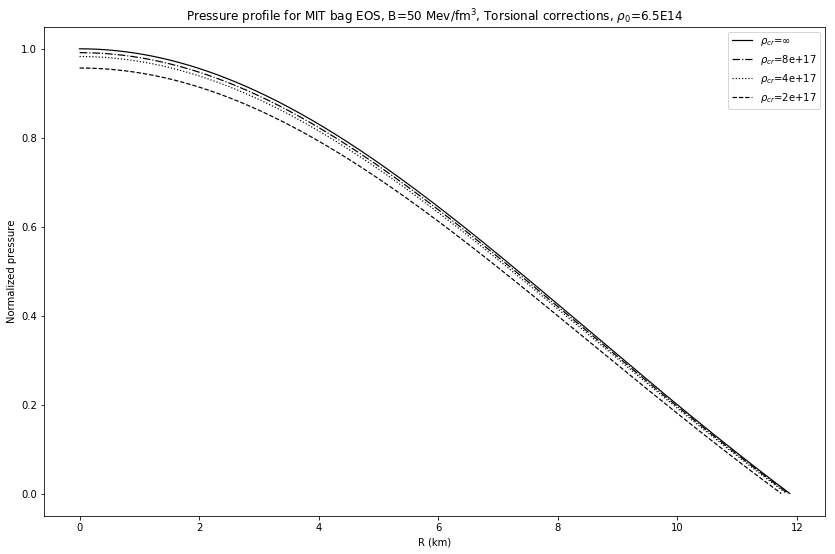

In [0]:
cen_dens=8 #6.5e14
boundary,bry_tor=dens_len_matcher(rb_cl_mit,rb_tor_mit,cen_dens)
plt.plot(rs[0:boundary]/1E5,
         p_cl_mit[cen_dens,0:boundary]/p_cl_mit[cen_dens,0],'k',lw=1.2,
         label=r'$\rho_{cr}$=$\infty$')
for i in range(2,-1,-1):
  plt.plot(rs[0:bry_tor[i]]/1E5,
           p_tor_mit[i,cen_dens,0:bry_tor[i]]/p_cl_mit[cen_dens,0],
           lines[i],c='k',lw=1.2,
           label=r"$\rho_{cr}$"+'={}'.format(((i+1)**2-(i+1)+2)*1.0E17))
plt.legend()
plt.rcParams['figure.figsize'] = [14,9]
plt.title('Pressure profile for MIT bag EOS, '+
          'B=50 Mev/fm$^3$, Torsional corrections,'+r' $\rho_0$=6.5E14')
plt.ylabel('Normalized pressure')
plt.xlabel('R (km)')
plt.show()